In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import datetime
import os.path
import backtrader as bt
import pandas as pd


# Strategy

In [2]:

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)



# Analyzer Functions

In [3]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = round((total_won / total_closed) * 100,2)
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))
        
def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))

def printSharpeRatio(analyzer):
    SRatio = round(analyzer,4)
    print('Sharpe Ratio: {}'.format(SRatio))

# TestStrategy - In Sample Execution  

In [4]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Load data
fname_symbol = 'CL'
folder_name = '5min'
suffix = '5min_20160103_20190405'

df = pd.read_parquet('D:/study/dalpha/DecisiveWorkflowResearch-master/data/processed/5min/CL_5min_20160103_20190405.parquet')
df = (df.resample('4h', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
df.columns = [col_name.lower() for col_name in df.columns]
df = df.dropna()

data = bt.feeds.PandasData(dataname = df['2016-01-01':'2018-01-05'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Months)

cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_slippage_fixed(0.01)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strategies = cerebro.run()
firstStrat = strategies[0]


# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
#cerebro.plot(volume=False, iplot=False)

#Finally plot the end results
#cerebro.plot(style='candlestick')


Starting Portfolio Value: 100000.00
2018-01-05, (MA Period 15) Ending Value 90852.72
Final Portfolio Value: 90852.72


# Trade Results

In [5]:
# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
printSQN(firstStrat.analyzers.sqn.get_analysis())
printSharpeRatio(firstStrat.analyzers.sharpe.get_analysis()['sharperatio'])


Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               0              180            47             133            
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               26.11          4              14             -9147.28       
SQN: -0.59
Sharpe Ratio: -0.1418


# optimization 

In [6]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
strats = cerebro.optstrategy(
    TestStrategy,
    maperiod=(26,51,100,200))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Months)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# Set the commission
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_slippage_fixed(0.01)

# Run over everything
results = cerebro.run(maxcpus=1)

2018-01-05, (MA Period 26) Ending Value 105295.71
2018-01-05, (MA Period 51) Ending Value 83651.01
2018-01-05, (MA Period 100) Ending Value 93297.89
2018-01-05, (MA Period 200) Ending Value 90431.75


# Print Optimization Analyzer results

In [7]:
#period_to_net_profit = []

for res in results:
    
    maperiod = res[0].params.maperiod
    print('************************')
    print('For mapperiod :', maperiod)
    print('************************')
    #trade_analysis = res[0].analyzers.ta.get_analysis()
    #sqn_analysis = res[0].analyzers.sqn.get_analysis()
    #sharpe_analysis = res[0].analyzers.sharpe.get_analysis()
    printTradeAnalysis(res[0].analyzers.ta.get_analysis())
    printSQN(res[0].analyzers.sqn.get_analysis())
    printSharpeRatio(res[0].analyzers.sharpe.get_analysis()['sharperatio'])


************************
For mapperiod : 26
************************
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               1              121            32             89             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               26.45          3              22             1112.37        
SQN: 0.08
Sharpe Ratio: 0.0548
************************
For mapperiod : 51
************************
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               1              108            21             87             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               19.44          2              24             -20532.33      
SQN: -1.71
Sharpe Ratio: -0.1836
************************
For mapperiod : 100
************************
Trade Analysis Results:
               Total Open     Total Closed   Tot

# Strategy :- Out-of-Sample  Execution

Starting Portfolio Value: 100000.00
2018-06-01, (MA Period 26) Ending Value 92932.95
Final Portfolio Value: 92932.95


<IPython.core.display.Javascript object>


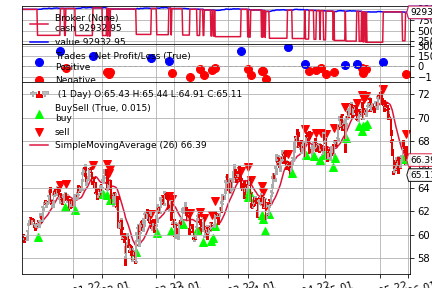

[[<Figure size 432x288 with 3 Axes>]]

In [8]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy, maperiod=26)

data = bt.feeds.PandasData(dataname = df['2018-01-01':'2018-06-01'])


# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Months)


# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# Set the commission
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_slippage_fixed(0.01)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
Results_OOS=cerebro.run()
OOS_Results=Results_OOS[0]

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Print out the graph
#cerebro.plot(volume=False, iplot=False)
cerebro.plot(style='candlestick',volume=False, iplot=True)

    

# Print Out-Of-Sample Analyzer results

In [9]:
# Print Analyzer Results
printTradeAnalysis(OOS_Results.analyzers.ta.get_analysis())
printSQN(OOS_Results.analyzers.sqn.get_analysis())
printSharpeRatio(OOS_Results.analyzers.sharpe.get_analysis()['sharperatio'])

Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               0              35             10             25             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               28.57          2              6              -7067.05       
SQN: -1.12
Sharpe Ratio: -0.534
